In [79]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import soundfile as sf


In [80]:
# Path to your extracted LibriSpeech dataset
DATA_PATH = r"C:\Users\P SAI\Desktop\SEM 4\Speech Processing\END-SEM-PROJECT\dataset"

# Set a sample rate for resampling audio
SAMPLE_RATE = 16000

# Max duration in seconds (optional trimming)
DURATION = 1  # seconds

# Number of MFCC features to extract
N_MFCC = 13


In [81]:
def extract_features(file_path, duration=DURATION, sample_rate=SAMPLE_RATE, n_mfcc=N_MFCC):
    try:
        signal, sr = librosa.load(file_path, sr=sample_rate)
        if len(signal) < duration * sample_rate:
            return None  # skip too short

        # Trim or pad to fixed length
        signal = signal[:duration * sample_rate]

        # Use librosa's MFCC extraction safely
        mfcc_feats = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_feats = np.mean(mfcc_feats.T, axis=0)
        return mfcc_feats
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [82]:
features = []
labels = []

# Reset speaker count
MAX_SPEAKERS = 5
speaker_count = 0

# Make sure to import: from glob import glob
from glob import glob
import os

features = []
labels = []

DATA_PATH = DATA_PATH  # <-- change this to your actual path
MAX_SPEAKERS = 5
speaker_count = 0

# Go through each speaker folder
for speaker_id in sorted(os.listdir(DATA_PATH)):
    speaker_path = os.path.join(DATA_PATH, speaker_id)
    if not os.path.isdir(speaker_path):
        continue

    # Find all .wav files recursively under the speaker's folder
    wav_files = glob(os.path.join(speaker_path, "**", "*.wav"), recursive=True)

    # Skip empty folders
    if len(wav_files) == 0:
        continue

    # Process each file
    for file_path in wav_files:
        mfcc_features = extract_features(file_path)  # You should have this function
        if mfcc_features is not None:
            features.append(mfcc_features)
            labels.append(speaker_id)

    # Count speaker only if files were added
    speaker_count += 1
    if speaker_count >= MAX_SPEAKERS:
        break


In [83]:
# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Encode speaker IDs
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print("Data shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Data shapes:
X_train: (5250, 13)
X_test: (2251, 13)
y_train: (5250,)
y_test: (2251,)


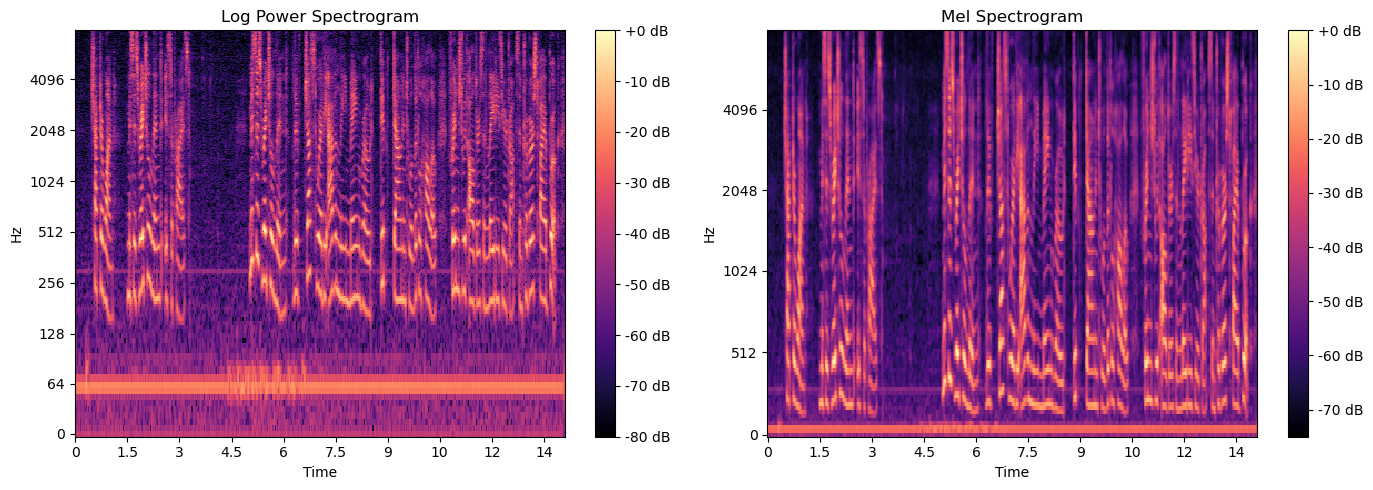

In [46]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrograms(file_path, sample_rate=16000):
    y, sr = librosa.load(file_path, sr=sample_rate)

    plt.figure(figsize=(14, 5))

    # 1. Regular Spectrogram
    plt.subplot(1, 2, 1)
    spec = np.abs(librosa.stft(y))
    db_spec = librosa.amplitude_to_db(spec, ref=np.max)
    librosa.display.specshow(db_spec, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Power Spectrogram')

    # 2. Mel-Spectrogram
    plt.subplot(1, 2, 2)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db_spec = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_db_spec, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    plt.tight_layout()
    plt.show()

# Example call
plot_spectrograms("LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac")


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       450
           1       0.84      0.87      0.86       450
           2       0.94      0.95      0.95       451
           3       0.93      0.92      0.92       450
           4       1.00      0.99      0.99       450

    accuracy                           0.92      2251
   macro avg       0.92      0.92      0.92      2251
weighted avg       0.92      0.92      0.92      2251



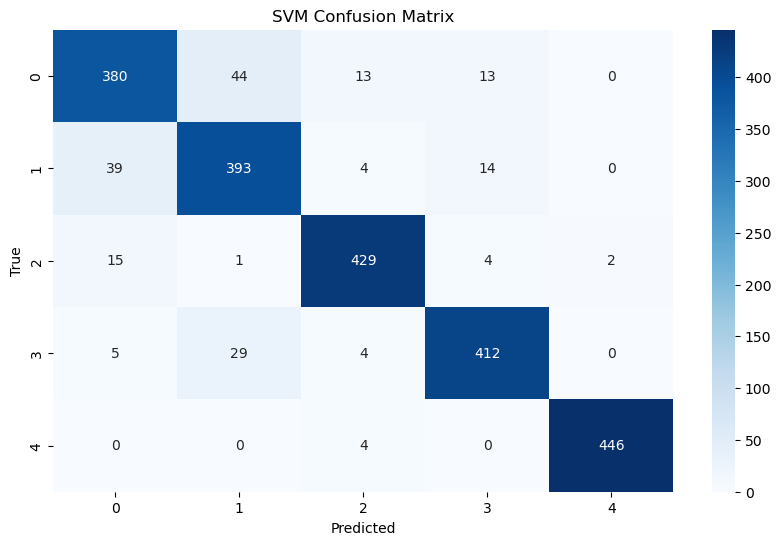

In [84]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# SVM Model
svm_model = SVC(kernel='rbf', C=10, gamma='scale')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       450
           1       0.85      0.90      0.87       450
           2       0.95      0.93      0.94       451
           3       0.92      0.91      0.91       450
           4       0.97      0.99      0.98       450

    accuracy                           0.91      2251
   macro avg       0.91      0.91      0.91      2251
weighted avg       0.91      0.91      0.91      2251



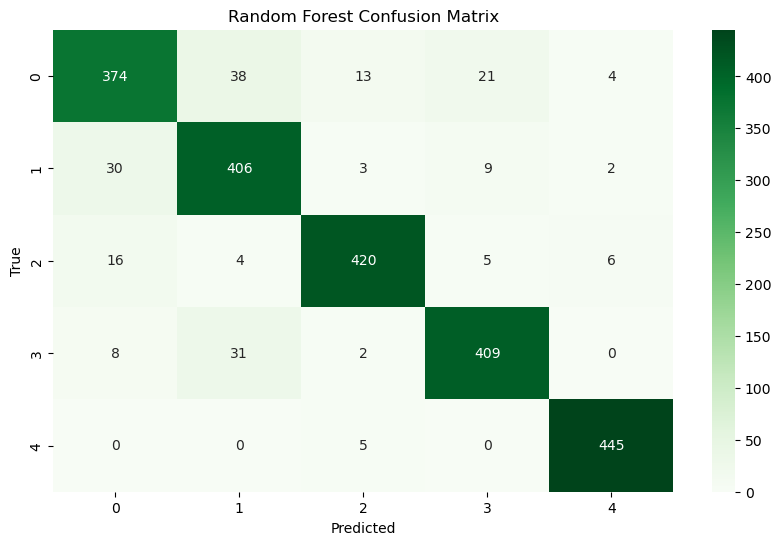

In [85]:
from sklearn.ensemble import RandomForestClassifier

# RF Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       450
           1       0.89      0.91      0.90       450
           2       0.97      0.95      0.96       451
           3       0.92      0.92      0.92       450
           4       0.99      0.99      0.99       450

    accuracy                           0.93      2251
   macro avg       0.93      0.93      0.93      2251
weighted avg       0.93      0.93      0.93      2251



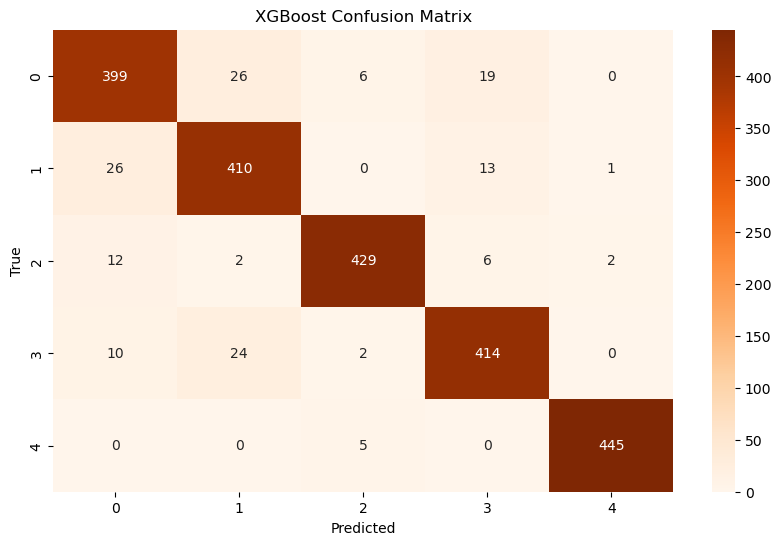

In [86]:
from xgboost import XGBClassifier

# XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       450
           1       0.83      0.83      0.83       450
           2       0.96      0.95      0.95       451
           3       0.89      0.90      0.89       450
           4       0.99      0.99      0.99       450

    accuracy                           0.90      2251
   macro avg       0.90      0.90      0.90      2251
weighted avg       0.90      0.90      0.90      2251



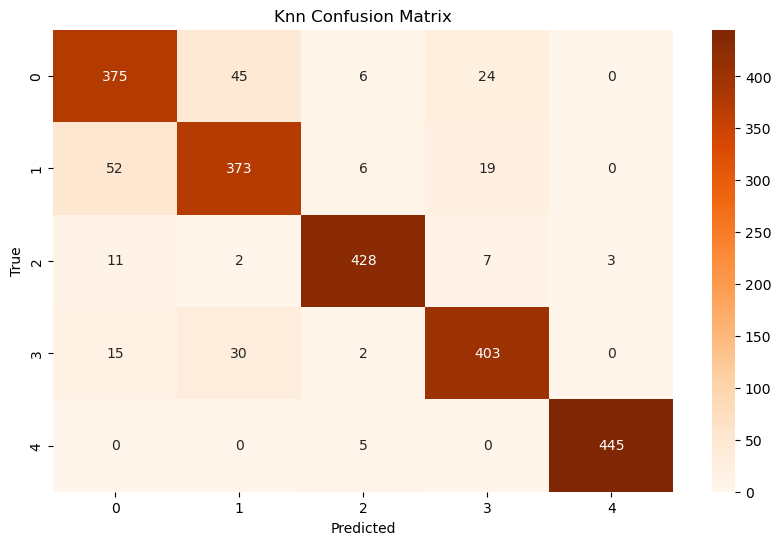

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Evaluation
y_pred_knn = knn_model.predict(X_test)

print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Oranges')
plt.title("Knn Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       450
           1       0.73      0.76      0.75       450
           2       0.87      0.85      0.86       451
           3       0.83      0.84      0.83       450
           4       0.94      0.96      0.95       450

    accuracy                           0.81      2251
   macro avg       0.81      0.81      0.81      2251
weighted avg       0.81      0.81      0.81      2251



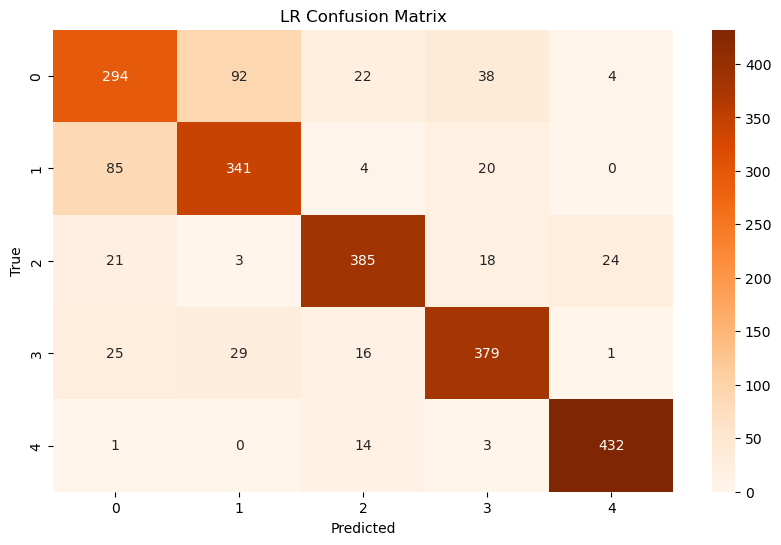

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg_model.fit(X_train, y_train)

# Evaluation
y_pred_logreg = logreg_model.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg), annot=True, fmt='d', cmap='Oranges')
plt.title("LR Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [89]:
# Core libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Audio processing
import librosa
import librosa.display

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [90]:
# Convert encoded labels (e.g., [0,1,2,...]) to one-hot format
y_onehot = to_categorical(y_encoded)

# New train-test split (for one-hot encoded labels)
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

print("DL-ready shapes:")
print("X_train:", X_train.shape)
print("y_train (one-hot):", y_train.shape)


DL-ready shapes:
X_train: (6000, 13)
y_train (one-hot): (6000, 5)


In [91]:
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [92]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the ANN or CNN model
history = ann_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3396 - loss: 5.9032 - val_accuracy: 0.6933 - val_loss: 1.0150
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5494 - loss: 1.3060 - val_accuracy: 0.7333 - val_loss: 0.7016
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6202 - loss: 0.9135 - val_accuracy: 0.7533 - val_loss: 0.6195
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6886 - loss: 0.7571 - val_accuracy: 0.7742 - val_loss: 0.5366
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7305 - loss: 0.6535 - val_accuracy: 0.8117 - val_loss: 0.5029
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7384 - loss: 0.6221 - val_accuracy: 0.8150 - val_loss: 0.4681
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7783 - loss: 0.5459 - val_accuracy: 0.8458 - val_loss: 0.4345
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7698 - loss: 0.5410 - val_accu

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report (ANN):
                   precision    recall  f1-score   support

Benjamin_Netanyau       0.88      0.94      0.91       300
 Jens_Stoltenberg       0.96      0.81      0.88       300
    Julia_Gillard       0.98      0.97      0.97       301
  Magaret_Tarcher       0.89      0.99      0.94       300
   Nelson_Mandela       1.00      0.98      0.99       300

         accuracy                           0.94      1501
        macro avg       0.94      0.94      0.94      1501
     weighted avg       0.94      0.94      0.94      1501



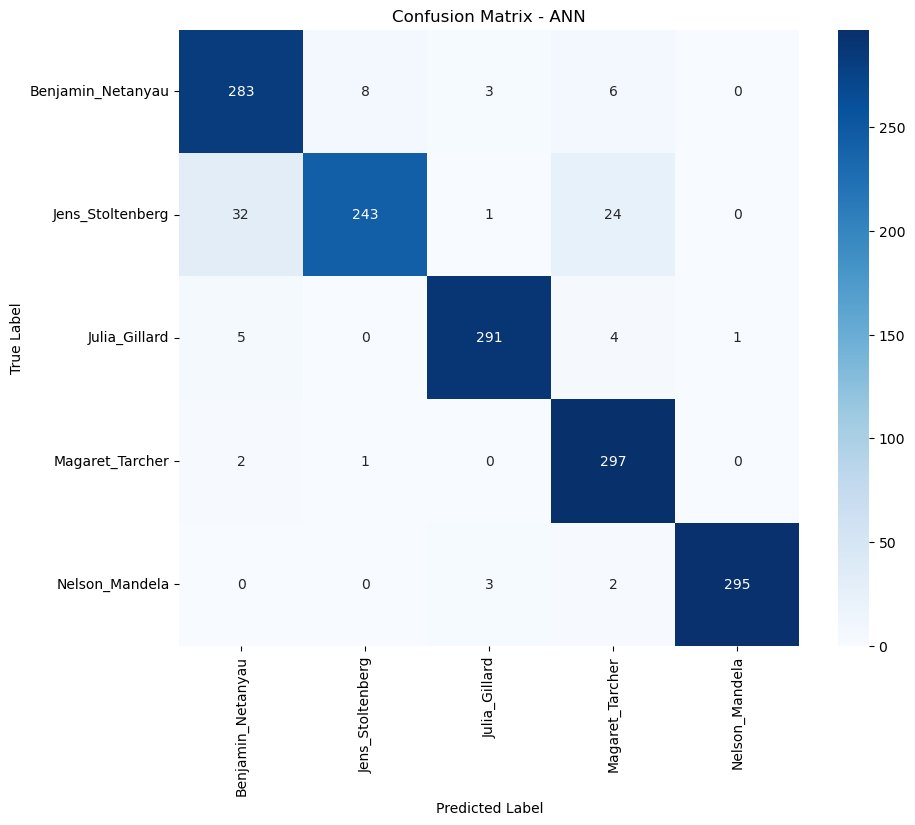

In [93]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities and then take the class with highest probability
y_pred_probs = ann_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report (ANN):")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - ANN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [94]:
# Assuming MFCCs were extracted without averaging, e.g., shape = (timesteps, n_mfcc)
X_cnn = X[..., np.newaxis]  # Add channel dimension if needed

cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=X_cnn.shape[1:]),
    MaxPooling1D(2),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [95]:
history = cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5322 - loss: 1.1869 - val_accuracy: 0.7792 - val_loss: 0.5725
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7725 - loss: 0.5925 - val_accuracy: 0.8375 - val_loss: 0.4359
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8140 - loss: 0.4687 - val_accuracy: 0.8458 - val_loss: 0.4016
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8452 - loss: 0.4071 - val_accuracy: 0.8817 - val_loss: 0.3244
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8617 - loss: 0.3813 - val_accuracy: 0.8850 - val_loss: 0.3128
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8647 - loss: 0.3626 - val_accuracy: 0.8983 - val_loss: 0.2634
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8863 - loss: 0.3114 - val_accuracy: 0.9067 - val_loss: 0.2786
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8989 - loss: 0.2969 - val_accu

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
CNN Model Classification Report:
                   precision    recall  f1-score   support

Benjamin_Netanyau       0.91      0.93      0.92       300
 Jens_Stoltenberg       0.94      0.88      0.91       300
    Julia_Gillard       0.96      0.94      0.95       301
  Magaret_Tarcher       0.94      0.97      0.95       300
   Nelson_Mandela       0.97      0.99      0.98       300

         accuracy                           0.94      1501
        macro avg       0.94      0.94      0.94      1501
     weighted avg       0.94      0.94      0.94      1501



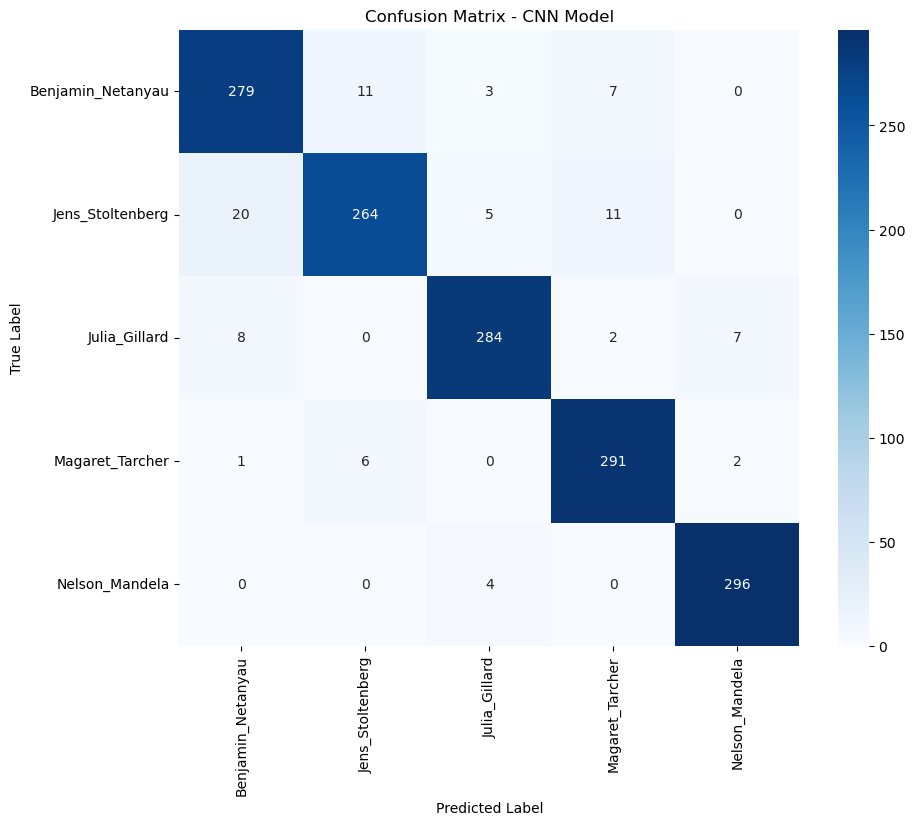

In [96]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict probabilities
y_pred_probs = cnn_model.predict(X_test)

# Convert predictions and ground truth from one-hot to label indices
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Get original class labels (optional, for readable report)
label_names = le.classes_

# Print classification report
print("CNN Model Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_names))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN Model")
plt.show()



In [97]:
# Cell 1: Import all necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm  # Using tqdm.notebook for Jupyter compatibility
import pickle
import time
import warnings
warnings.filterwarnings('ignore')



In [28]:
DATA_PATH = "LibriSpeech/train-clean-100"

In [98]:
# Cell 2: Define the MultiResolutionHTF class (feature extraction)
class MultiResolutionHTF:
    """
    Multi-Resolution Harmonic-Temporal Feature Fusion (MR-HTF) preprocessing
    
    This novel preprocessing technique combines harmonic structure analysis with 
    temporal dynamics at multiple resolutions for speaker identification.
    """
    def __init__(self, sr=16000, n_fft=1024, hop_length=256, n_mels=40, 
                 f0_min=50, f0_max=500, n_harmonics=8):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.f0_min = f0_min
        self.f0_max = f0_max
        self.n_harmonics = n_harmonics
        self.feature_dim = n_mels + n_harmonics + 10  # Final feature dimension
        
    def extract_features(self, audio_path, max_duration=5.0):
        """Extract MR-HTF features from an audio file"""
        try:
            # Load audio (with resampling if needed)
            y, sr = librosa.load(audio_path, sr=self.sr)
            
            # Ensure consistent length (5 sec max)
            target_length = int(max_duration * self.sr)
            if len(y) > target_length:
                y = y[:target_length]
            elif len(y) < target_length:
                # Zero-pad if audio is shorter
                y = np.pad(y, (0, target_length - len(y)))
            
            # 1. Dynamic Filter Bank Analysis (Mel Spectrogram with Emphasis)
            mel_spec = librosa.feature.melspectrogram(
                y=y, sr=self.sr, n_fft=self.n_fft, 
                hop_length=self.hop_length, n_mels=self.n_mels
            )
            mel_spec = librosa.power_to_db(mel_spec)
            
            # 2. Harmonic Structure Extraction
            # Extract fundamental frequency (F0) and harmonics
            f0, voiced_flag, voiced_probs = librosa.pyin(
                y, fmin=self.f0_min, fmax=self.f0_max, sr=self.sr
            )
            
            # Replace NaN values with zeros in F0
            f0 = np.nan_to_num(f0)
            
            # Extract harmonics features
            harmonic_features = self._extract_harmonic_features(y, f0)
            
            # 3. Multi-Resolution Temporal Features
            short_term = self._extract_temporal_features(y, window_size=int(0.02*self.sr))
            medium_term = self._extract_temporal_features(y, window_size=int(0.2*self.sr))
            long_term = self._extract_temporal_features(y, window_size=int(1.0*self.sr))
            
            # 4. Feature Fusion with Information Bottleneck
            # Compute global statistics from mel spectrogram
            mel_mean = np.mean(mel_spec, axis=1)
            mel_std = np.std(mel_spec, axis=1)
            
            # F0 statistics
            f0_mean = np.mean(f0[voiced_flag == 1]) if np.any(voiced_flag == 1) else 0
            f0_std = np.std(f0[voiced_flag == 1]) if np.any(voiced_flag == 1) else 0
            
            # Combine features
            temporal_features = np.concatenate([
                np.mean(short_term, axis=1),
                np.mean(medium_term, axis=1),
                np.mean(long_term, axis=1)
            ])
            
            # Get most discriminative features from mel spectrogram
            mel_features = self._apply_information_bottleneck(mel_mean, mel_std)
            
            # Concatenate all features
            combined_features = np.concatenate([
                mel_features, 
                harmonic_features,
                [f0_mean, f0_std], 
                temporal_features
            ])
            
            return combined_features
            
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return None
            
    def _extract_harmonic_features(self, y, f0):
        """Extract harmonic features based on fundamental frequency"""
        # Compute spectrogram
        D = np.abs(librosa.stft(y, n_fft=self.n_fft, hop_length=self.hop_length))
        
        # Get time-frequency representation
        times = librosa.times_like(D, sr=self.sr, hop_length=self.hop_length)
        freqs = librosa.fft_frequencies(sr=self.sr, n_fft=self.n_fft)
        
        # Initialize harmonic features array
        harmonic_features = np.zeros(self.n_harmonics)
        
        # Get median F0 for stable estimation
        median_f0 = np.median(f0[f0 > 0]) if np.any(f0 > 0) else 0
        
        if median_f0 > 0:
            for i in range(self.n_harmonics):
                harmonic_freq = median_f0 * (i + 1)
                if harmonic_freq < self.sr / 2:  # Below Nyquist
                    # Find closest bin
                    idx = np.argmin(np.abs(freqs - harmonic_freq))
                    # Get energy around the harmonic (averaging a few bins)
                    start_idx = max(0, idx - 2)
                    end_idx = min(len(freqs), idx + 3)
                    harmonic_energy = np.mean(np.mean(D[start_idx:end_idx, :], axis=1))
                    harmonic_features[i] = harmonic_energy
                    
        # Normalize
        if np.sum(harmonic_features) > 0:
            harmonic_features = harmonic_features / np.sum(harmonic_features)
            
        return harmonic_features
            
    def _extract_temporal_features(self, y, window_size):
        """Extract temporal features at different resolutions"""
        # Compute short-time energy
        energy = librosa.feature.rms(y=y, frame_length=window_size, hop_length=window_size//2)
        
        # Compute short-time zero-crossing rate
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=window_size, hop_length=window_size//2)
        
        # Compute spectral centroid
        centroid = librosa.feature.spectral_centroid(y=y, sr=self.sr, 
                                                    n_fft=window_size, hop_length=window_size//2)
        
        return np.vstack([energy, zcr, centroid])
    
    def _apply_information_bottleneck(self, mel_mean, mel_std):
        """Apply information bottleneck to select most discriminative features"""
        # For now, we'll use a simple approach: combine mean and std with emphasis on lower mels
        # In a real implementation, you would train an information bottleneck model
        weights = np.exp(-0.1 * np.arange(len(mel_mean)))
        weights = weights / np.sum(weights)
        
        # Weight the features
        weighted_mean = mel_mean * weights
        weighted_std = mel_std * weights
        
        # Select most informative features
        combined = np.concatenate([weighted_mean, weighted_std])
        
        return combined



In [99]:
# Cell 3: Define the HierAttentionResQuantNet model
class HierAttentionResQuantNet:
    """
    Hierarchical Attention Residual Quantized Network (HA-RQNet)
    
    A novel architecture designed for speaker identification with:
    - Hierarchical feature processing
    - Quantized bottleneck layers
    - Progressive dimensionality reduction
    - Prototype-based classification
    """
    def __init__(self, input_dim, num_speakers, embedding_dim=128):
        self.input_dim = input_dim
        self.num_speakers = num_speakers
        self.embedding_dim = embedding_dim
        self.model = self._build_model()
        
    def _build_model(self):
        """Build the HA-RQNet model"""
        # Input layer
        inputs = tf.keras.layers.Input(shape=(self.input_dim,))
        x = tf.keras.layers.Reshape((self.input_dim, 1))(inputs)
        
        # First convolutional block (32 filters)
        x = self._conv_attention_block(x, filters=32, kernel_size=3)
        x = self._quantized_bottleneck(x, codebook_size=64)
        
        # Second convolutional block (64 filters)
        x = self._conv_attention_block(x, filters=64, kernel_size=3)
        x = self._quantized_bottleneck(x, codebook_size=128)
        
        # Third convolutional block (128 filters)
        x = self._conv_attention_block(x, filters=128, kernel_size=3)
        x = self._quantized_bottleneck(x, codebook_size=256)
        
        # Global temporal aggregation
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        
        # Embedding layer
        embeddings = tf.keras.layers.Dense(self.embedding_dim)(x)
        embeddings = tf.keras.layers.LayerNormalization()(embeddings)
        embeddings = tf.keras.layers.Activation('tanh')(embeddings)
        
        # Prototype-based classification
        prototype_layer = tf.keras.layers.Dense(self.num_speakers, use_bias=False, 
                                               name='prototype_layer')(embeddings)
        outputs = tf.keras.layers.Activation('softmax')(prototype_layer)
        
        # Create model
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
        
        # Create embeddings model (for speaker verification tasks)
        embeddings_model = tf.keras.models.Model(inputs=inputs, outputs=embeddings)
        
        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        self.embeddings_model = embeddings_model
        return model
    
    def _conv_attention_block(self, x, filters, kernel_size):
        """Convolutional block with attention mechanism"""
        # Conv layer
        conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                    padding='same')(x)
        conv = tf.keras.layers.BatchNormalization()(conv)
        conv = tf.keras.layers.Activation('relu')(conv)
        
        # Self-attention
        attention = tf.keras.layers.Dense(filters)(conv)
        attention = tf.keras.layers.Activation('tanh')(attention)
        attention = tf.keras.layers.Dense(1)(attention)
        attention = tf.keras.layers.Softmax(axis=1)(attention)  # ✅ Fixed here
        
        # Apply attention
        attended = tf.keras.layers.Multiply()([conv, attention])
        
        # Residual connection
        if x.shape[-1] == filters:
            output = tf.keras.layers.Add()([x, attended])
        else:
            # Project input to match dimensions
            projection = tf.keras.layers.Conv1D(filters=filters, kernel_size=1)(x)
            output = tf.keras.layers.Add()([projection, attended])
            
        return output

    
    def _quantized_bottleneck(self, x, codebook_size):
        """Simplified vector quantization bottleneck layer"""
        # In a full implementation, this would be a proper VQ layer
        # Here we simulate the effect with a bottleneck + discretization
        
        # Reduce dimensionality
        bottleneck = tf.keras.layers.Conv1D(filters=x.shape[-1]//2, kernel_size=1)(x)
        
        # Apply strong activation to push values toward extremes (simulating quantization)
        bottleneck = tf.keras.layers.BatchNormalization()(bottleneck)
        bottleneck = tf.keras.layers.Activation('tanh')(bottleneck)
        bottleneck = tf.keras.layers.Lambda(lambda x: 2.0 * x)(bottleneck)  # Scale to amplify
        bottleneck = tf.keras.layers.Activation('tanh')(bottleneck)
        
        # Expand back
        output = tf.keras.layers.Conv1D(filters=x.shape[-1], kernel_size=1)(bottleneck)
        
        # Residual connection
        output = tf.keras.layers.Add()([x, output])
        
        return output
    
    def summary(self):
        """Display model summary"""
        return self.model.summary()
    
    def get_embeddings(self, features):
        """Extract speaker embeddings for given features"""
        return self.embeddings_model.predict(features)



In [100]:
# Cell 4: Define the SpeakerIdentificationSystem class
class SpeakerIdentificationSystem:
    """
    Complete Speaker Identification System
    
    Integrates preprocessing, model training, and evaluation components.
    """
    def __init__(self, data_path, max_speakers=None, sr=16000, max_audio_duration=5.0):
        self.data_path = data_path
        self.max_speakers = max_speakers
        self.sr = sr
        self.max_audio_duration = max_audio_duration
        self.preprocessor = MultiResolutionHTF(sr=sr)
        self.speaker_encoder = None
        self.model = None
        
    def load_and_preprocess_data(self):
        """Load audio files and extract features"""
        print("Loading and preprocessing audio files...")
        
        # Get all audio files
        audio_files = []
        speaker_ids = []
        
        for speaker_dir in os.listdir(self.data_path):
            speaker_path = os.path.join(self.data_path, speaker_dir)
            if os.path.isdir(speaker_path):
                # Add speaker ID
                speaker_ids.append(speaker_dir)
                
                # Limit number of speakers if specified
                if self.max_speakers and len(speaker_ids) > self.max_speakers:
                    break
                    
                # Get audio files for this speaker
                for audio_file in os.listdir(speaker_path):
                    if audio_file.endswith(('.wav', '.mp3', '.flac')):
                        audio_path = os.path.join(speaker_path, audio_file)
                        audio_files.append({
                            'path': audio_path,
                            'speaker': speaker_dir
                        })
        
        # Encode speaker labels
        self.speaker_encoder = LabelEncoder()
        speaker_ids = self.speaker_encoder.fit_transform(speaker_ids)
        
        # Extract features
        features = []
        labels = []
        
        for audio_file in tqdm(audio_files, desc="Extracting features"):
            feature_vector = self.preprocessor.extract_features(
                audio_file['path'], max_duration=self.max_audio_duration
            )
            
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(self.speaker_encoder.transform([audio_file['speaker']])[0])
        
        # Convert to numpy arrays
        features = np.array(features)
        labels = np.array(labels)
        
        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(
            features, labels, test_size=0.3, random_state=42, stratify=labels
        )
        
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
        
        print(f"Data loaded: {len(X_train)} training, {len(X_val)} validation, {len(X_test)} test samples")
        print(f"Number of speakers: {len(self.speaker_encoder.classes_)}")
        
        self.data = {
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val,
            'X_test': X_test,
            'y_test': y_test
        }
        
        return self.data
    
    def build_model(self):
        """Build the HA-RQNet model"""
        if not hasattr(self, 'data'):
            raise ValueError("Data must be loaded before building the model")
            
        # Get the number of speakers
        num_speakers = len(self.speaker_encoder.classes_)
        
        # Get input dimension from the data
        input_dim = self.data['X_train'].shape[1]
        
        # Create model
        self.model = HierAttentionResQuantNet(input_dim, num_speakers)
        print("Model built successfully:")
        self.model.summary()
        
        return self.model
    
    def train(self, epochs=200, batch_size=32):
            """Train the speaker identification model"""
            if self.model is None:
                raise ValueError("Model must be built before training")
                
            # Set up callbacks (only ModelCheckpoint)
            callbacks = [
                tf.keras.callbacks.ModelCheckpoint(
                    'best_speaker_id_model.h5', monitor='val_accuracy', 
                    save_best_only=True, verbose=1
                )
            ]
            
            # Train the model
            print("\nTraining model...")
            history = self.model.model.fit(
                self.data['X_train'], self.data['y_train'],
                validation_data=(self.data['X_val'], self.data['y_val']),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=tf.keras.callbacks.ModelCheckpoint(
                    'best_speaker_id_model.h5', monitor='val_accuracy', 
                    save_best_only=True
                )
            )
            
            # Plot training history
            self._plot_training_history(history)
            
            return history

        
        
    
    def evaluate(self):
        """Evaluate the trained model on test data"""
        if self.model is None:
            raise ValueError("Model must be trained before evaluation")
            
        # Evaluate on test set
        print("\nEvaluating model on test data...")
        test_loss, test_acc = self.model.model.evaluate(
            self.data['X_test'], self.data['y_test'], verbose=1
        )
        
        print(f"Test accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}")
        
        # Get predictions
        y_pred = np.argmax(self.model.model.predict(self.data['X_test']), axis=1)
        
        # Generate classification report
        speaker_names = self.speaker_encoder.classes_
        report = classification_report(
            self.data['y_test'], y_pred, target_names=speaker_names
        )
        print("\nClassification Report:")
        print(report)
        
        # Plot confusion matrix
        self._plot_confusion_matrix(self.data['y_test'], y_pred, speaker_names)
        
        # Get embeddings for visualization
        embeddings = self.model.get_embeddings(self.data['X_test'])
        self._plot_embeddings(embeddings, self.data['y_test'])
        
        return {
            'accuracy': test_acc,
            'loss': test_loss,
            'report': report,
            'predictions': y_pred,
            'true_labels': self.data['y_test'],
            'embeddings': embeddings
        }
    
    def save_model(self, model_path='speaker_id_model'):
        """Save the trained model and preprocessing configuration"""
        if self.model is None:
            raise ValueError("Model must be trained before saving")
            
        # Create directory if it doesn't exist
        os.makedirs(model_path, exist_ok=True)
        
        # Save TensorFlow model
        self.model.model.save(os.path.join(model_path, 'model.h5'))
        
        # Save embeddings model
        self.model.embeddings_model.save(os.path.join(model_path, 'embeddings_model.h5'))
        
        # Save speaker encoder
        with open(os.path.join(model_path, 'speaker_encoder.pkl'), 'wb') as f:
            pickle.dump(self.speaker_encoder, f)
            
        print(f"Model saved to {model_path}")
    
    def load_model(self, model_path='speaker_id_model'):
        """Load a previously trained model"""
        # Load TensorFlow model
        model_file = os.path.join(model_path, 'model.h5')
        embeddings_model_file = os.path.join(model_path, 'embeddings_model.h5')
        encoder_file = os.path.join(model_path, 'speaker_encoder.pkl')
        
        if not all(os.path.exists(f) for f in [model_file, embeddings_model_file, encoder_file]):
            raise FileNotFoundError("One or more model files not found")
            
        # Load models
        loaded_model = tf.keras.models.load_model(model_file)
        loaded_embeddings_model = tf.keras.models.load_model(embeddings_model_file)
        
        # Load encoder
        with open(encoder_file, 'rb') as f:
            self.speaker_encoder = pickle.load(f)
            
        # Create new model instance
        input_dim = loaded_model.input_shape[1]
        num_speakers = len(self.speaker_encoder.classes_)
        self.model = HierAttentionResQuantNet(input_dim, num_speakers)
        
        # Replace model weights
        self.model.model = loaded_model
        self.model.embeddings_model = loaded_embeddings_model
        
        print(f"Model loaded from {model_path}")
        print(f"Number of speakers: {num_speakers}")
        
        return self.model
    
    def identify_speaker(self, audio_path):
        """Identify speaker in a given audio file"""
        if self.model is None:
            raise ValueError("Model must be loaded before identification")
            
        # Extract features
        features = self.preprocessor.extract_features(audio_path)
        
        if features is None:
            return "Error processing audio file"
            
        # Reshape for model input
        features = np.expand_dims(features, axis=0)
        
        # Get prediction
        prediction = self.model.model.predict(features)[0]
        speaker_idx = np.argmax(prediction)
        confidence = prediction[speaker_idx]
        
        # Get speaker label
        speaker = self.speaker_encoder.inverse_transform([speaker_idx])[0]
        
        return {
            'speaker': speaker,
            'confidence': float(confidence),
            'all_probabilities': {
                self.speaker_encoder.inverse_transform([i])[0]: float(prediction[i])
                for i in range(len(prediction))
            }
        }
    
    def _plot_training_history(self, history):
        """Plot training and validation metrics"""
        plt.figure(figsize=(12, 5))
        
        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()
    
    def _plot_confusion_matrix(self, y_true, y_pred, class_names):
        """Plot confusion matrix"""
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Normalize
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Normalized)')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()
    
    def _plot_embeddings(self, embeddings, labels):
        """Plot speaker embeddings using t-SNE"""
        from sklearn.manifold import TSNE
        
        # Reduce dimensions with t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Plot
        plt.figure(figsize=(12, 10))
        
        # Get unique labels
        unique_labels = np.unique(labels)
        
        # Plot each speaker
        for label in unique_labels:
            mask = labels == label
            plt.scatter(
                embeddings_2d[mask, 0], 
                embeddings_2d[mask, 1],
                label=self.speaker_encoder.inverse_transform([label])[0],
                alpha=0.7
            )
            
        plt.title('Speaker Embeddings (t-SNE)')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('speaker_embeddings.png')
        plt.show()



In [101]:
# Cell 5: Example Usage - Setting up the system and loading data
# This cell shows how to create a system and load data
# Uncomment and modify the following code to run it


# Set the path to your data directory
# Your data should be organized as:
# data_path/
#   speaker1/
#     audio1.wav
#     audio2.wav
#     ...
#   speaker2/
#     audio1.wav
#     ...
#   ...

data_path = r"C:\Users\P SAI\Desktop\SEM 4\Speech Processing\END-SEM-PROJECT\dataset"  # Change this to your data path

# Create the speaker identification system
system = SpeakerIdentificationSystem(
    data_path=data_path,
    max_speakers=5  # Set to a number if you want to limit the number of speakers
)

# Load and preprocess data
data = system.load_and_preprocess_data()




Loading and preprocessing audio files...


Extracting features:   0%|          | 0/7501 [00:00<?, ?it/s]

Data loaded: 5250 training, 1125 validation, 1126 test samples
Number of speakers: 5


Model built successfully:


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 99)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 99, 1)     │          0 │ input_layer_16[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_137 (Conv1D) │ (None, 99, 32)    │        128 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 99, 32)    │        128 │ conv1d_137[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_157      │ (None, 99, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 99, 32)    │      1,056 │ activation_157[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_158      │ (None, 99, 32)    │          0 │ dense_89[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 99, 1)     │         33 │ activation_158[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_33          │ (None, 99, 1)     │          0 │ dense_90[0][0]    │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_138 (Conv1D) │ (None, 99, 32)    │         64 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_33         │ (None, 99, 32)    │          0 │ activation_157[0… │
│ (Multiply)          │                   │            │ softmax_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_66 (Add)        │ (None, 99, 32)    │          0 │ conv1d_138[0][0], │
│                     │                   │            │ multiply_33[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_139 (Conv1D) │ (None, 99, 16)    │        528 │ add_66[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 99, 16)    │         64 │ conv1d_139[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_159      │ (None, 99, 16)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_33 (Lambda)  │ (None, 99, 16)    │          0 │ activation_159[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_160      │ (None, 99, 16)    │          0 │ lambda_33[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_140 (Conv1D) │ (None, 99, 32)    │        544 │ activation_160[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_67 (Add)        │ (None, 99, 32)    │          0 │ add_66[0][0],     │
│                     │                   │            │ conv1d_140[0][0]

 Total params: 104,083 (406.57 KB)

 Trainable params: 103,411 (403.95 KB)

 Non-trainable params: 672 (2.62 KB)


Training model...
Epoch 1/200
163/165 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2284 - loss: 1.6427

165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.2284 - loss: 1.6422 - val_accuracy: 0.2089 - val_loss: 1.7625
Epoch 2/200
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2439 - loss: 1.5796

165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.2441 - loss: 1.5795 - val_accuracy: 0.2391 - val_loss: 1.5720
Epoch 3/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.2589 - loss: 1.5631 - val_accuracy: 0.2062 - val_loss: 1.7935
Epoch 4/200
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2566 - loss: 1.5570

165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.2567 - loss: 1.5569 - val_accuracy: 0.2427 - val_loss: 1.5544
Epoch 5/200
164/165 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2782 - loss: 1.5515

165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.2783 - loss: 1.5512 - val_accuracy: 0.3289 - val_loss: 1.4977
Epoch 6/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.3057 - loss: 1.4791 - val_accuracy: 0.2124 - val_loss: 2.2059
Epoch 7/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3345 - loss: 1.4987 - val_accuracy: 0.2169 - val_loss: 2.0482
Epoch 8/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3642 - loss: 1.3990 - val_accuracy: 0.2800 - val_loss: 1.7280
Epoch 9/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3779 - loss: 1.3682 - val_accuracy: 0.2338 - val_loss: 1.8168
Epoch 10/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3858 - loss: 1.3474

165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3858 - loss: 1.3473 - val_accuracy: 0.3387 - val_loss: 1.5086
Epoch 11/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3877 - loss: 1.3747 - val_accuracy: 0.3316 - val_loss: 1.5309
Epoch 12/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3939 - loss: 1.3336

165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3939 - loss: 1.3335 - val_accuracy: 0.4062 - val_loss: 1.3551
Epoch 13/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4036 - loss: 1.3301 - val_accuracy: 0.2889 - val_loss: 1.5792
Epoch 14/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4017 - loss: 1.3296 - val_accuracy: 0.3538 - val_loss: 1.4696
Epoch 15/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3842 - loss: 1.3524 - val_accuracy: 0.3031 - val_loss: 1.5093
Epoch 16/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.4118 - loss: 1.3092 - val_accuracy: 0.3449 - val_loss: 1.5431
Epoch 17/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.4044 - loss: 1.3221 - val_accuracy: 0.3707 - val_loss: 1.3616
Epoch 18/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.4201 - loss: 1.3060 - val_accuracy: 0.3902 - val_loss: 1.3377
Epoch 19/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.4100 - loss: 1.3110 - v

165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.5555 - loss: 1.0755 - val_accuracy: 0.5422 - val_loss: 1.0727
Epoch 42/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5339 - loss: 1.1069 - val_accuracy: 0.2524 - val_loss: 3.1425
Epoch 43/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.4897 - loss: 1.2681 - val_accuracy: 0.2062 - val_loss: 3.3706
Epoch 44/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5252 - loss: 1.1109 - val_accuracy: 0.2578 - val_loss: 2.3881
Epoch 45/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5374 - loss: 1.0792 - val_accuracy: 0.4462 - val_loss: 1.2406
Epoch 46/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5722 - loss: 1.0368 - val_accuracy: 0.2453 - val_loss: 3.5113
Epoch 47/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5818 - loss: 1.0471 - val_accuracy: 0.3707 - val_loss: 1.5295
Epoch 48/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.5816 - loss: 1.0224 -

165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.5905 - loss: 0.9984 - val_accuracy: 0.6231 - val_loss: 0.9973
Epoch 52/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5316 - loss: 1.1990 - val_accuracy: 0.3147 - val_loss: 2.0621
Epoch 53/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.6054 - loss: 0.9786 - val_accuracy: 0.2667 - val_loss: 2.2425
Epoch 54/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5762 - loss: 1.0136 - val_accuracy: 0.2151 - val_loss: 2.7968
Epoch 55/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5923 - loss: 1.0281 - val_accuracy: 0.2000 - val_loss: 3.6166
Epoch 56/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5932 - loss: 1.0303 - val_accuracy: 0.2000 - val_loss: 4.1982
Epoch 57/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5767 - loss: 1.0318 - val_accuracy: 0.2222 - val_loss: 2.8893
Epoch 58/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.5887 - loss: 1.0197 

165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.6472 - loss: 0.8700 - val_accuracy: 0.6409 - val_loss: 0.8504
Epoch 95/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.6505 - loss: 0.8573 - val_accuracy: 0.3476 - val_loss: 3.1467
Epoch 96/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.6683 - loss: 0.8321 - val_accuracy: 0.3520 - val_loss: 2.0490
Epoch 97/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.6418 - loss: 0.8761 - val_accuracy: 0.3813 - val_loss: 2.8197
Epoch 98/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.6340 - loss: 0.8997 - val_accuracy: 0.2356 - val_loss: 3.6429
Epoch 99/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.6412 - loss: 0.8899 - val_accuracy: 0.4124 - val_loss: 2.4683
Epoch 100/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.6465 - loss: 0.8925 - val_accuracy: 0.4444 - val_loss: 1.6587
Epoch 101/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.6393 - loss: 0.8

165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.6539 - loss: 0.8343 - val_accuracy: 0.6480 - val_loss: 0.8645
Epoch 109/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.6576 - loss: 0.8302 - val_accuracy: 0.3013 - val_loss: 3.6188
Epoch 110/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.6273 - loss: 0.8972 - val_accuracy: 0.4516 - val_loss: 1.9847
Epoch 111/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.6650 - loss: 0.8401 - val_accuracy: 0.2196 - val_loss: 3.9599
Epoch 112/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.6088 - loss: 0.9236 - val_accuracy: 0.3964 - val_loss: 2.7351
Epoch 113/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.6551 - loss: 0.8621 - val_accuracy: 0.4151 - val_loss: 2.6916
Epoch 114/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6620 - loss: 0.8308 - val_accuracy: 0.3733 - val_loss: 2.7411
Epoch 115/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.6624 - los

165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.6237 - loss: 0.8992 - val_accuracy: 0.6711 - val_loss: 0.7968
Epoch 143/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.6756 - loss: 0.7978 - val_accuracy: 0.3040 - val_loss: 3.4844
Epoch 144/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.6641 - loss: 0.8200 - val_accuracy: 0.4027 - val_loss: 3.4451
Epoch 145/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.6086 - loss: 1.0317 - val_accuracy: 0.4969 - val_loss: 1.5683
Epoch 146/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5940 - loss: 1.0755 - val_accuracy: 0.3582 - val_loss: 1.8671
Epoch 147/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.6490 - loss: 0.8357 - val_accuracy: 0.2773 - val_loss: 3.8176
Epoch 148/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.6695 - loss: 0.8089 - val_accuracy: 0.6427 - val_loss: 0.8641
Epoch 149/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.6761 - loss:

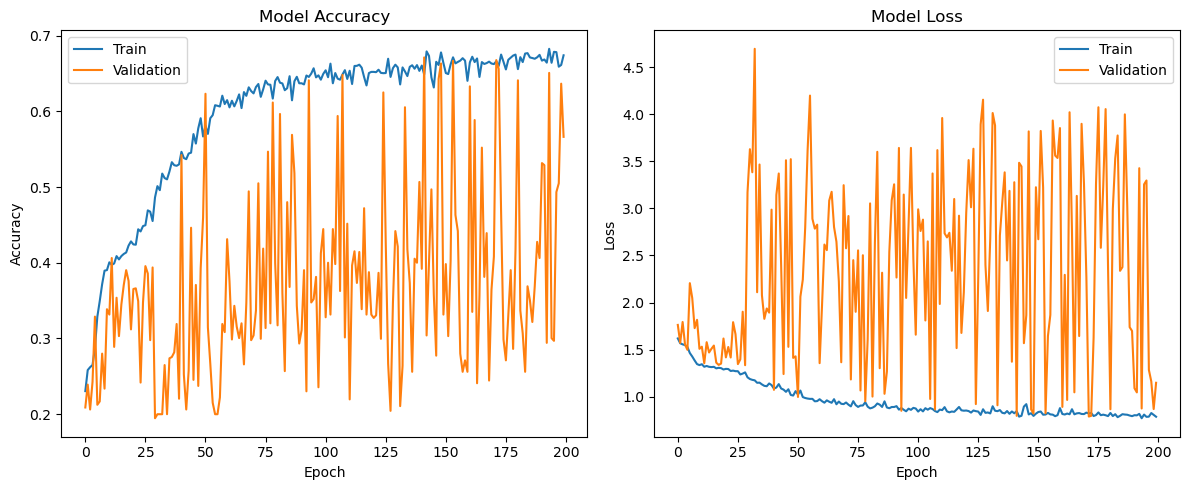

In [106]:
# Cell 6: Example Usage - Building and training the model

# Build the model
system.build_model()

# Train the model
# You can adjust epochs and batch size
history = system.train(epochs=200, batch_size=32)





Evaluating model on test data...
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5444 - loss: 1.1149
Test accuracy: 0.5675
Test loss: 1.0667
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

Classification Report:
                   precision    recall  f1-score   support

Benjamin_Netanyau       0.50      0.30      0.38       225
 Jens_Stoltenberg       0.76      0.39      0.51       225
    Julia_Gillard       0.44      0.79      0.56       226
  Magaret_Tarcher       0.87      0.67      0.76       225
   Nelson_Mandela       0.53      0.69      0.60       225

         accuracy                           0.57      1126
        macro avg       0.62      0.57      0.56      1126
     weighted avg       0.62      0.57      0.56      1126



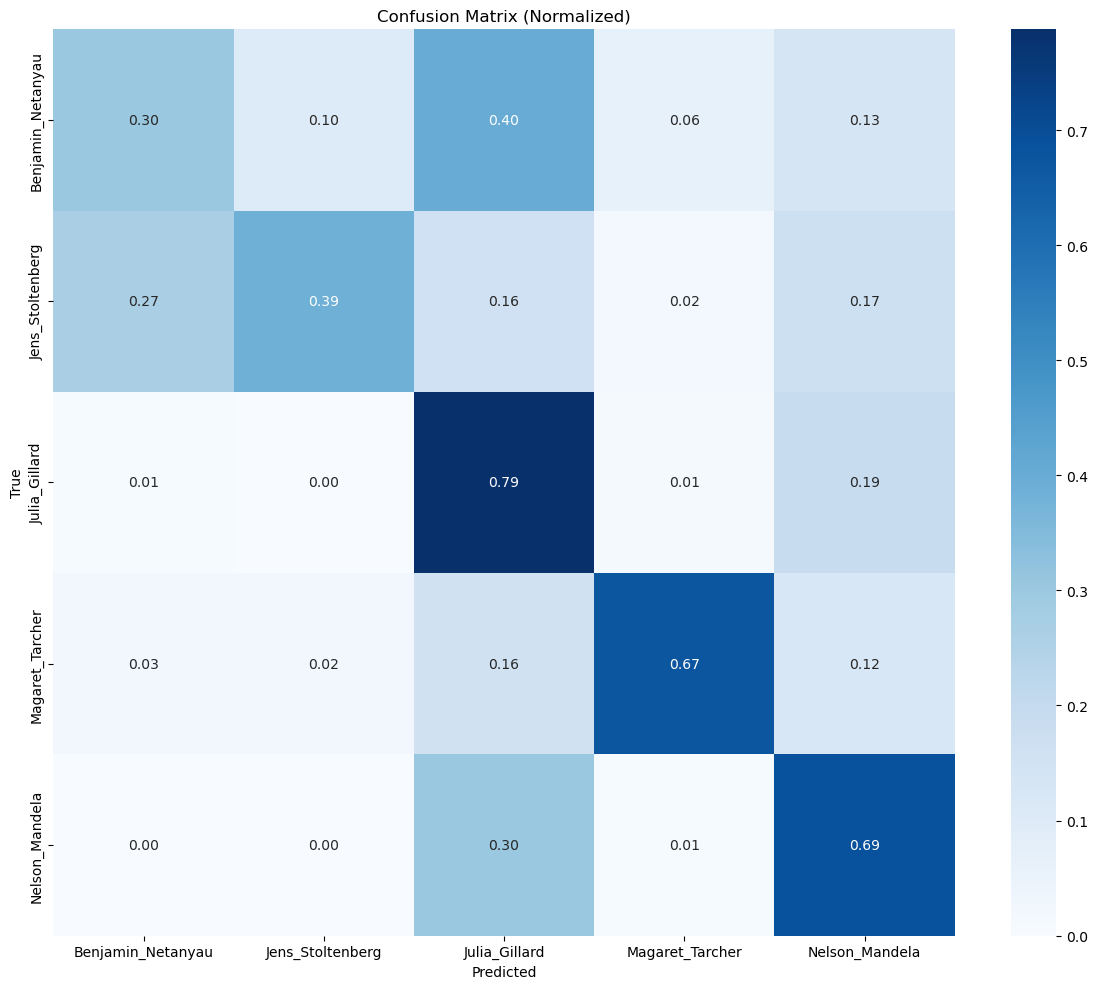

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


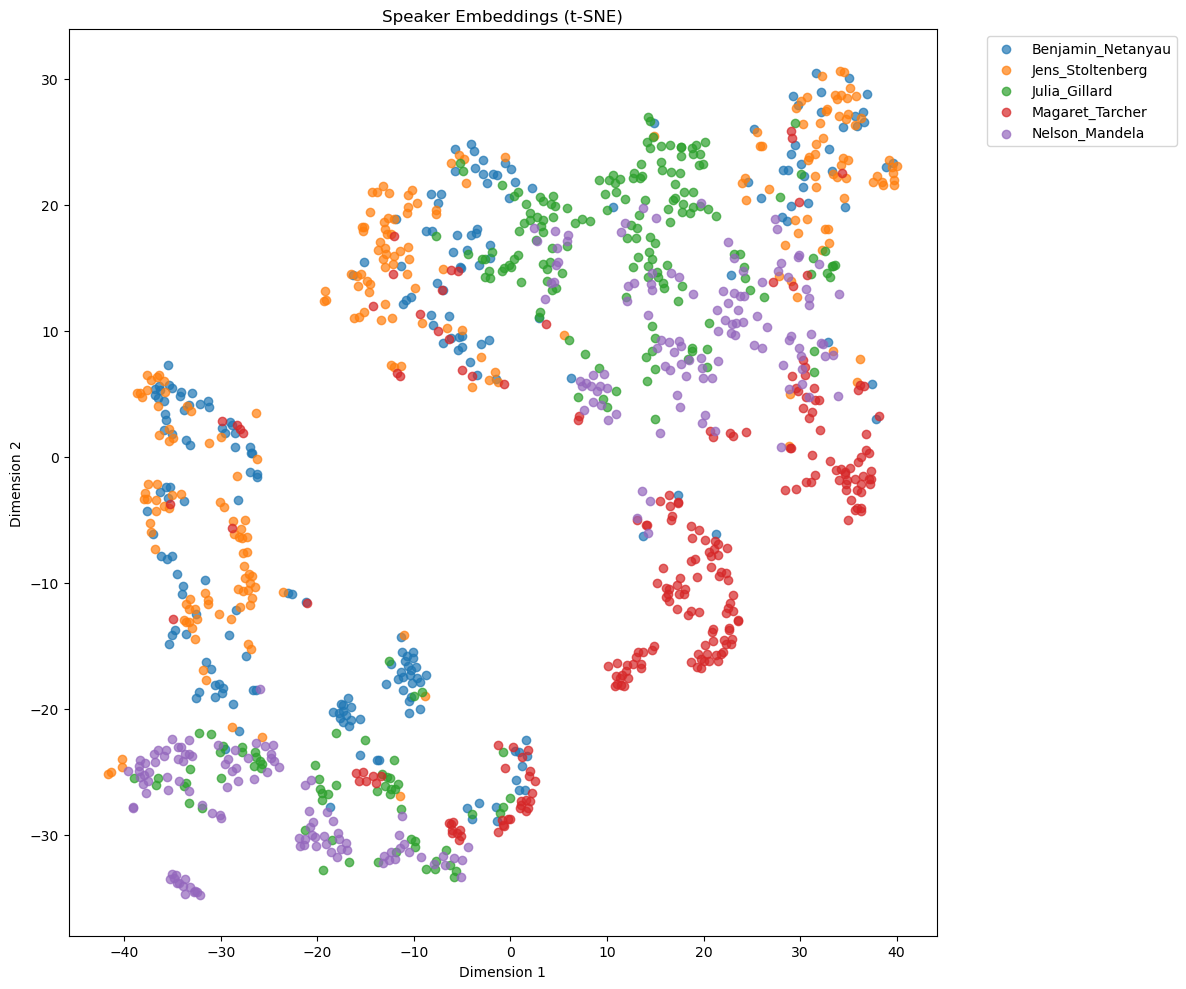

Test accuracy: 0.5675


In [107]:
# Cell 7: Example Usage - Evaluating the model

# Evaluate the model on the test set
evaluation = system.evaluate()

# Print test accuracy
print(f"Test accuracy: {evaluation['accuracy']:.4f}")




In [108]:
# Cell 8: Example Usage - Saving and loading the model

# Save the model
system.save_model(model_path='speaker_id_model')

# Load a previously saved model
# system = SpeakerIdentificationSystem(data_path=data_path)  # Create new system
# system.load_model(model_path='speaker_id_model')




Model saved to speaker_id_model


In [ ]:
# Cell 9: Example Usage - Identifying a speaker in an audio file
"""
# Identify speaker in a new audio file
audio_path = "path/to/unknown_speaker.wav"  # Change this to your audio file
result = system.identify_speaker(audio_path)

print(f"\nSpeaker Identification Result:")
print(f"Speaker: {result['speaker']}")
print(f"Confidence: {result['confidence']:.4f}")

print("\nAll probabilities:")
# Sort by probability (descending)
sorted_probs = sorted(
    result['all_probabilities'].items(),
    key=lambda x: x[1],
    reverse=True
)
for speaker, prob in sorted_probs[:5]:  # Show top 5
    print(f"{speaker}: {prob:.4f}")
"""